In [53]:
from joblib import Parallel, delayed
from __init__ import *
import Setting as _C
reload(_C)
import utils as _U
reload(_U)
import Features as _F
reload(_F)
import Dataloader as _D
reload(_D)

<module 'Dataloader' from 'c:\\Users\\shuai.song\\data\\Causis\\CTA_Trend\\Dataloader.py'>

In [54]:
trading_logs = {}
all_buy = pd.DataFrame()
all_sell = pd.DataFrame()
all_total = pd.DataFrame()

for com in _D.commodities.keys():
    com_log = np.load(f'output/trading_logs/{_C.VERSION}/{com}_logs.npy', allow_pickle=True)
    com_log = com_log.tolist() # [BUY_log, SELL_log, TOTAL_log]
    trading_logs[com] = com_log

In [224]:
def Judge_Pos(com):
    ddf = pd.read_csv(f'output/features/{com}_features.csv')
    ddf = ddf.set_index('CLOCK.1')

    ddf['signal'] = np.zeros(ddf.shape[0])
    clock_list = ddf['CLOCK'].to_list()

    for i in range(trading_logs[com][0].shape[0]):
        entry = trading_logs[com][0].iloc[i]
        start = entry['open_bar']
        end = entry['close_bar']
        ddf['signal'].loc[start: end] = 1

    for i in range(trading_logs[com][1].shape[0]):
        entry = trading_logs[com][1].iloc[i]
        start = entry['open_bar']
        end = entry['close_bar']
        ddf['signal'].loc[start: end] = -1

    return ddf

In [55]:
F_data=  {}
## Positions
for com in tqdm(_D.commodities.keys(), desc='loading data'):
    ddf = pd.read_csv(f'output/features/{_C.VERSION}/{com}_features.csv')
    ddf = ddf.set_index('CLOCK', drop=False)
    F_data[com] = ddf

loading data: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


In [17]:
# F_data=  {}
# tasks = []
# ## Positions
# for com in _C.commodities.keys():
#     tasks.append(delayed(Judge_Pos)(com))

# multi_work = Parallel(n_jobs=8, backend='threading', verbose=80)
# res = multi_work(tasks)

# for com in _C.commodities.keys():
#     F_data[com] = res[list(_C.commodities.keys()).index(com)]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    8.3s
[Parallel(n_jobs=8)]: Done   2 out of  15 | elapsed:   10.0s remaining:  1.1min
[Parallel(n_jobs=8)]: Done   3 out of  15 | elapsed:   10.3s remaining:   41.4s
[Parallel(n_jobs=8)]: Done   4 out of  15 | elapsed:   11.0s remaining:   30.3s
[Parallel(n_jobs=8)]: Done   5 out of  15 | elapsed:   11.2s remaining:   22.5s
[Parallel(n_jobs=8)]: Done   6 out of  15 | elapsed:   11.4s remaining:   17.1s
[Parallel(n_jobs=8)]: Done   7 out of  15 | elapsed:   14.0s remaining:   16.0s
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:   14.7s remaining:   12.9s
[Parallel(n_jobs=8)]: Done   9 out of  15 | elapsed:   16.3s remaining:   10.9s
[Parallel(n_jobs=8)]: Done  10 out of  15 | elapsed:   20.0s remaining:   10.0s
[Parallel(n_jobs=8)]: Done  11 out of  15 | elapsed:   20.1s remaining:    7.2s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:   20.6

In [50]:
def plot_all(scom, t_start, t_end):
    stmp = F_data[scom][t_start:t_end].copy(deep=True)

    stmp['signal'] = stmp['position']/np.abs(stmp['position'])
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 5), dpi=150, sharex=True)
    axes[0].tick_params(labelsize=7)
    axes[1].tick_params(labelsize=7)

    ## Subplot 0
    # K bars
    sdf = pd.DataFrame()
    sdf['CLOCK'] = stmp['CLOCK'].apply(lambda x: pd.to_datetime(x))
    sdf = sdf.set_index('CLOCK')
    sdf['Open'] = stmp['OPEN']
    sdf['Close'] = stmp['CLOSE']
    sdf['High'] = stmp['HIGH']
    sdf['Low'] = stmp['LOW']
    sdf['Volume'] = stmp['VOLUME']

    mc = mpf.make_marketcolors(up='red', down='green', edge='black')
    s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc, y_on_right=False)
    mpf.plot(sdf, ax = axes[0], type='candle', style = s, ylabel='')
    
    # Super Trends
    stmp['UB_S'].loc[stmp['STD_S']== 1] = np.nan
    stmp['LB_S'].loc[stmp['STD_S']==-1] = np.nan

    stmp['UB_L'].loc[stmp['STD_L']== 1] = np.nan
    stmp['LB_L'].loc[stmp['STD_L']==-1] = np.nan

    stmp['UB_P'].loc[stmp['STD_P']== 1] = np.nan
    stmp['LB_P'].loc[stmp['STD_P']==-1] = np.nan

    stmp['UB_S'].plot(ax=axes[0], color='g', linestyle='--', alpha=0.8, linewidth=0.6)
    stmp['LB_S'].plot(ax=axes[0], color='r', linestyle='--', alpha=0.8, linewidth=0.6)

    stmp['UB_L'].plot(ax=axes[0], color='skyblue', linestyle='-.', alpha=0.8, linewidth=1.)
    stmp['LB_L'].plot(ax=axes[0], color='orange', linestyle='-.', alpha=0.8, linewidth=1.)

    # stmp['UB_P'].plot(ax=axes[0], color='blue', linestyle='-', alpha=0.8, linewidth=1.2)
    # stmp['LB_P'].plot(ax=axes[0], color='purple', linestyle='-', alpha=0.8, linewidth=1.2)

    axes[0].legend()

    ## Subplot 1
    stmp['CLOSE'].plot(ax=axes[1], color='b', alpha=0.8, linewidth=0.8)
    ax_twin = axes[1].twinx()
    ax_twin.tick_params(labelsize=7)
    ax_twin.set_ylim(-1,1)
    axes[1].legend(loc='upper right')

    BUY_POS = stmp.copy(deep=True)
    BUY_POS['signal'].loc[BUY_POS['signal']!=1]=0
    plt.bar(BUY_POS.index.to_list(), BUY_POS['signal'], color='pink', alpha=0.5, label='BUY Pos')

    SELL_POS = stmp.copy(deep=True)
    SELL_POS['signal'].loc[SELL_POS['signal']!=-1]=0
    plt.bar(SELL_POS.index.to_list(), SELL_POS['signal'], color='green', alpha=0.5, label='SELL Pos')
    ax_twin.legend(loc='upper left')

    x_ticks = []
    for i in range(stmp.shape[0]):
        if i % 10 == 0:
            x_ticks.append(stmp['CLOCK'].iloc[i])
        else:
            x_ticks.append('')
    ax_twin.set_xticklabels(labels=x_ticks,visible=True)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

In [ ]:
COM.loc[(COM['STD_S']==1) & (COM['STD_L_Fork']==1) & (COM['STD_P']==-1)].loc['2022-08-05 09:01:00': '2022-08-09 09:40:00'] # BUY

In [61]:
rb_log = np.load('output/trading_logs/v4/rb_logs.npy', allow_pickle=True)

In [62]:
rb_log[0].loc['2021-08-04 00:00:00':]

,open_bar,close_bar,open_price,close_price,close_reason,gain,signal,open_date,close_date
open_bar,,,,,,,,,
2021-08-09 21:10:00,2021-08-09 21:10:00,2021-08-10 09:55:00,5379.0,5326.0,non,-53.0,BUY,2021-08-10,2021-08-10
2021-08-13 10:10:00,2021-08-13 10:10:00,2021-08-13 21:35:00,5449.0,5435.0,non,-14.0,BUY,2021-08-13,2021-08-16
2021-08-17 14:40:00,2021-08-17 14:40:00,2021-08-17 14:50:00,5375.0,5335.0,non,-40.0,BUY,2021-08-17,2021-08-17
2021-08-19 11:05:00,2021-08-19 11:05:00,2021-08-19 21:10:00,5025.0,4950.0,non,-75.0,BUY,2021-08-19,2021-08-20
2021-08-20 22:00:00,2021-08-20 22:00:00,2021-08-23 09:10:00,5136.0,5095.0,non,-41.0,BUY,2021-08-23,2021-08-23
...,...,...,...,...,...,...,...,...,...
2022-07-29 21:10:00,2022-07-29 21:10:00,2022-08-01 14:25:00,4031.0,4085.0,non,54.0,BUY,2022-08-01,2022-08-01
2022-08-08 09:50:00,2022-08-08 09:50:00,2022-08-08 22:35:00,4141.0,4117.0,non,-24.0,BUY,2022-08-08,2022-08-09
2022-08-10 21:10:00,2022-08-10 21:10:00,2022-08-10 22:00:00,4106.0,4063.0,non,-43.0,BUY,2022-08-11,2022-08-11


In [65]:
F_data['rb']['2021-08-04 00:00:00':].loc[F_data['rb']]

,CLOCK,SYMBOL,CLOCK.1,OPEN,HIGH,LOW,CLOSE,VOLUME,INTEREST,SETTLE,...,UB_L,LB_L,STD_L,UB_P,LB_P,STD_P,STD_S_Fork,trigger,dc_change,position
CLOCK,,,,,,,,,,,,,,,,,,,,,
2021-08-04 09:05:00,2021-08-04 09:05:00,R.CN.SHF.rb.0004,2021-08-04 09:05:00,5365.0,5379.0,5353.0,5374.0,38309.0,985322.0,0.0,...,5402.2,5322.3,1.0,5384.5,5343.6,1.0,0.0,0.0,0.0,1887.0
2021-08-04 09:10:00,2021-08-04 09:10:00,R.CN.SHF.rb.0004,2021-08-04 09:10:00,5375.0,5389.0,5375.0,5378.0,39081.0,990491.0,0.0,...,5402.2,5335.2,1.0,5384.5,5347.6,1.0,0.0,0.0,0.0,1887.0
2021-08-04 09:15:00,2021-08-04 09:15:00,R.CN.SHF.rb.0004,2021-08-04 09:15:00,5378.0,5383.0,5365.0,5366.0,24405.0,991157.0,0.0,...,5402.2,5335.2,1.0,5384.5,5347.6,1.0,0.0,0.0,0.0,1887.0
2021-08-04 09:20:00,2021-08-04 09:20:00,R.CN.SHF.rb.0004,2021-08-04 09:20:00,5366.0,5368.0,5357.0,5363.0,20959.0,991736.0,0.0,...,5402.2,5335.2,1.0,5384.5,5347.6,1.0,0.0,0.0,0.0,1887.0
2021-08-04 09:25:00,2021-08-04 09:25:00,R.CN.SHF.rb.0004,2021-08-04 09:25:00,5363.0,5370.0,5351.0,5357.0,18858.0,993650.0,0.0,...,5402.2,5335.2,1.0,5384.5,5347.6,1.0,0.0,0.0,0.0,1887.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-19 14:40:00,2022-08-19 14:40:00,R.CN.SHF.rb.0004,2022-08-19 14:40:00,3966.0,3966.0,3946.0,3948.0,61698.0,1517303.0,0.0,...,3998.0,3945.5,-1.0,3985.2,3940.7,-1.0,-0.0,0.0,0.0,0.0
2022-08-19 14:45:00,2022-08-19 14:45:00,R.CN.SHF.rb.0004,2022-08-19 14:45:00,3950.0,3955.0,3934.0,3936.0,58267.0,1521302.0,0.0,...,3991.0,3945.5,-1.0,3976.1,3940.7,-1.0,-0.0,0.0,0.0,0.0
2022-08-19 14:50:00,2022-08-19 14:50:00,R.CN.SHF.rb.0004,2022-08-19 14:50:00,3937.0,3938.0,3924.0,3927.0,71535.0,1522386.0,0.0,...,3977.8,3884.2,-1.0,3959.4,3902.6,-1.0,-0.0,0.0,0.0,0.0


In [25]:
rb_log[0].loc['2021-08-04 00:00:00':]

,open_bar,close_bar,open_price,close_price,close_reason,gain,signal,open_date,close_date
open_bar,,,,,,,,,
2021-08-04 10:10:00,2021-08-04 10:10:00,2021-08-05 21:10:00,5376.0,5329.0,Loss_Cut,-47.0,BUY,2021-08-04,2021-08-06
2021-08-09 21:10:00,2021-08-09 21:10:00,2021-08-09 21:55:00,5379.0,5332.0,Loss_Cut,-47.0,BUY,2021-08-10,2021-08-10
2021-08-10 09:10:00,2021-08-10 09:10:00,2021-08-10 09:50:00,5367.0,5338.0,Loss_Cut,-29.0,BUY,2021-08-10,2021-08-10
2021-08-13 10:10:00,2021-08-13 10:10:00,2021-08-13 13:50:00,5449.0,5447.0,Loss_Cut,-2.0,BUY,2021-08-13,2021-08-13
2021-08-13 14:30:00,2021-08-13 14:30:00,2021-08-13 21:15:00,5500.0,5461.0,Loss_Cut,-39.0,BUY,2021-08-13,2021-08-16
...,...,...,...,...,...,...,...,...,...
2022-08-01 11:00:00,2022-08-01 11:00:00,2022-08-01 14:10:00,4107.0,4092.0,Loss_Cut,-15.0,BUY,2022-08-01,2022-08-01
2022-08-08 09:50:00,2022-08-08 09:50:00,2022-08-08 13:35:00,4141.0,4121.0,Loss_Cut,-20.0,BUY,2022-08-08,2022-08-08
2022-08-10 21:10:00,2022-08-10 21:10:00,2022-08-10 21:50:00,4106.0,4067.0,Loss_Cut,-39.0,BUY,2022-08-11,2022-08-11


In [39]:
tmp_com = F_data['rb']

In [52]:
tmp_com['CLOCK'].loc['2021-08-04 10:10:00':].loc[tmp_com['STD_L']==-1][0]

'2021-08-04 22:25:00'

In [46]:
if tmp_com['CLOCK'].loc['2021-08-04 10:10:00':].loc[tmp_com['STD_L']==-1].shape[0]:
    print('1')
else:
    print('2')

1


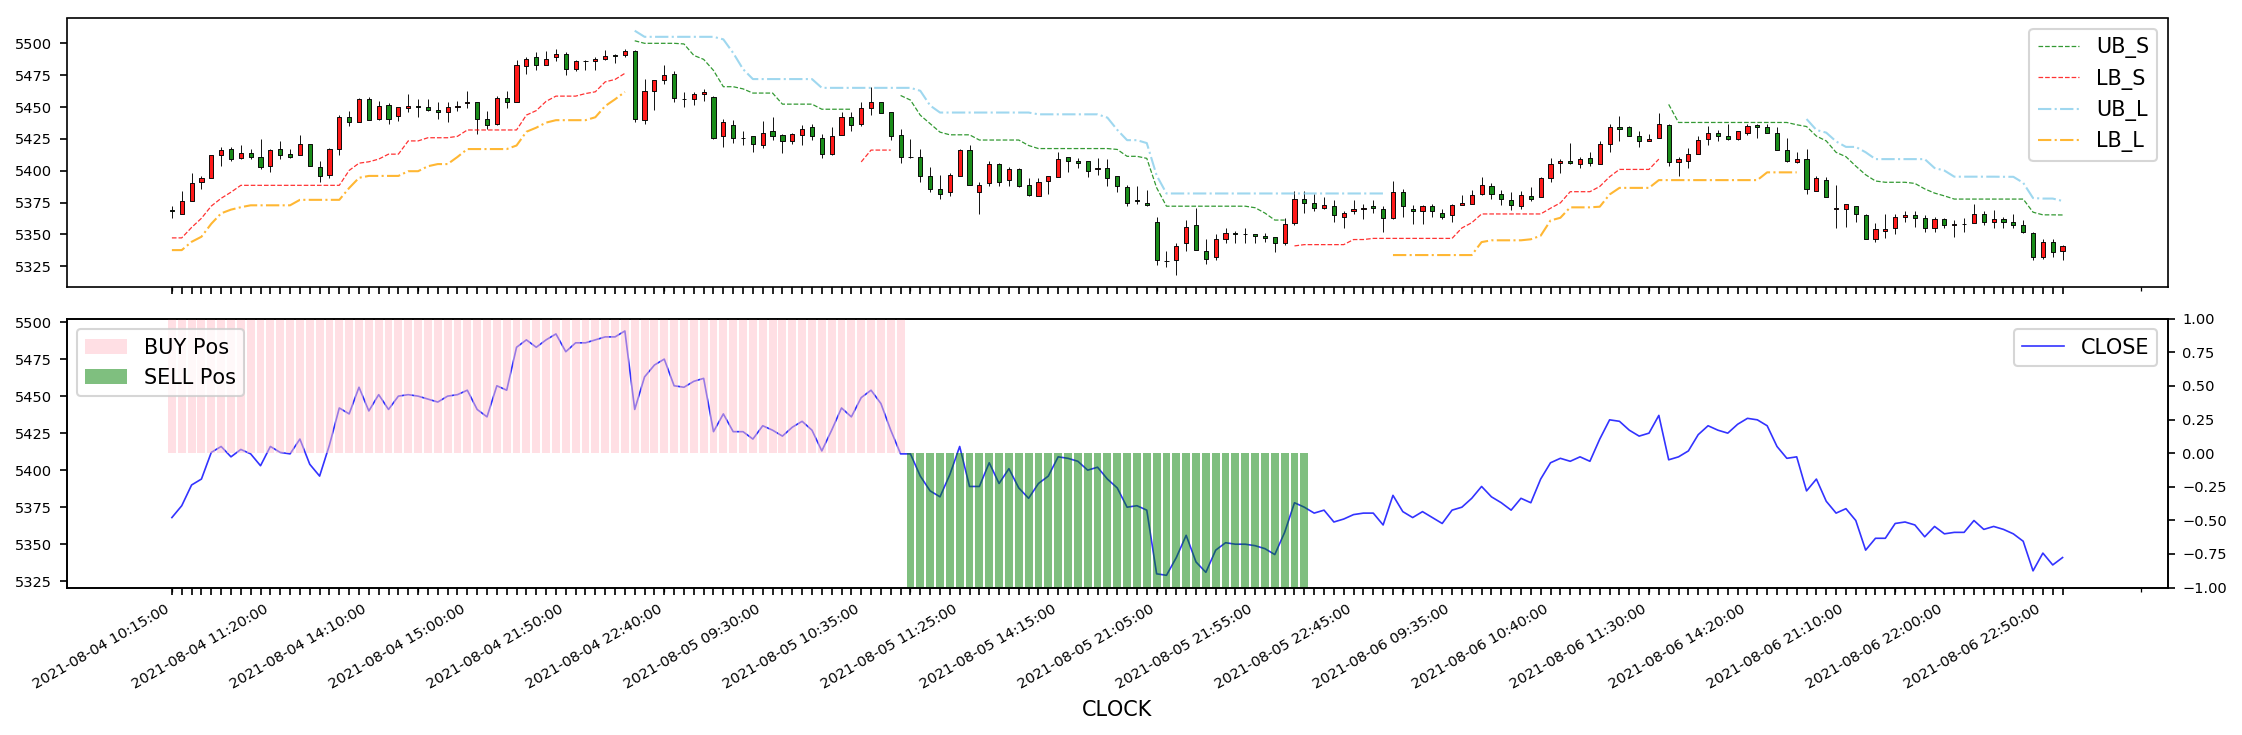

In [56]:
plot_all('rb', '2021-08-04 10:10:00	', '2021-08-07 10:10:00	')

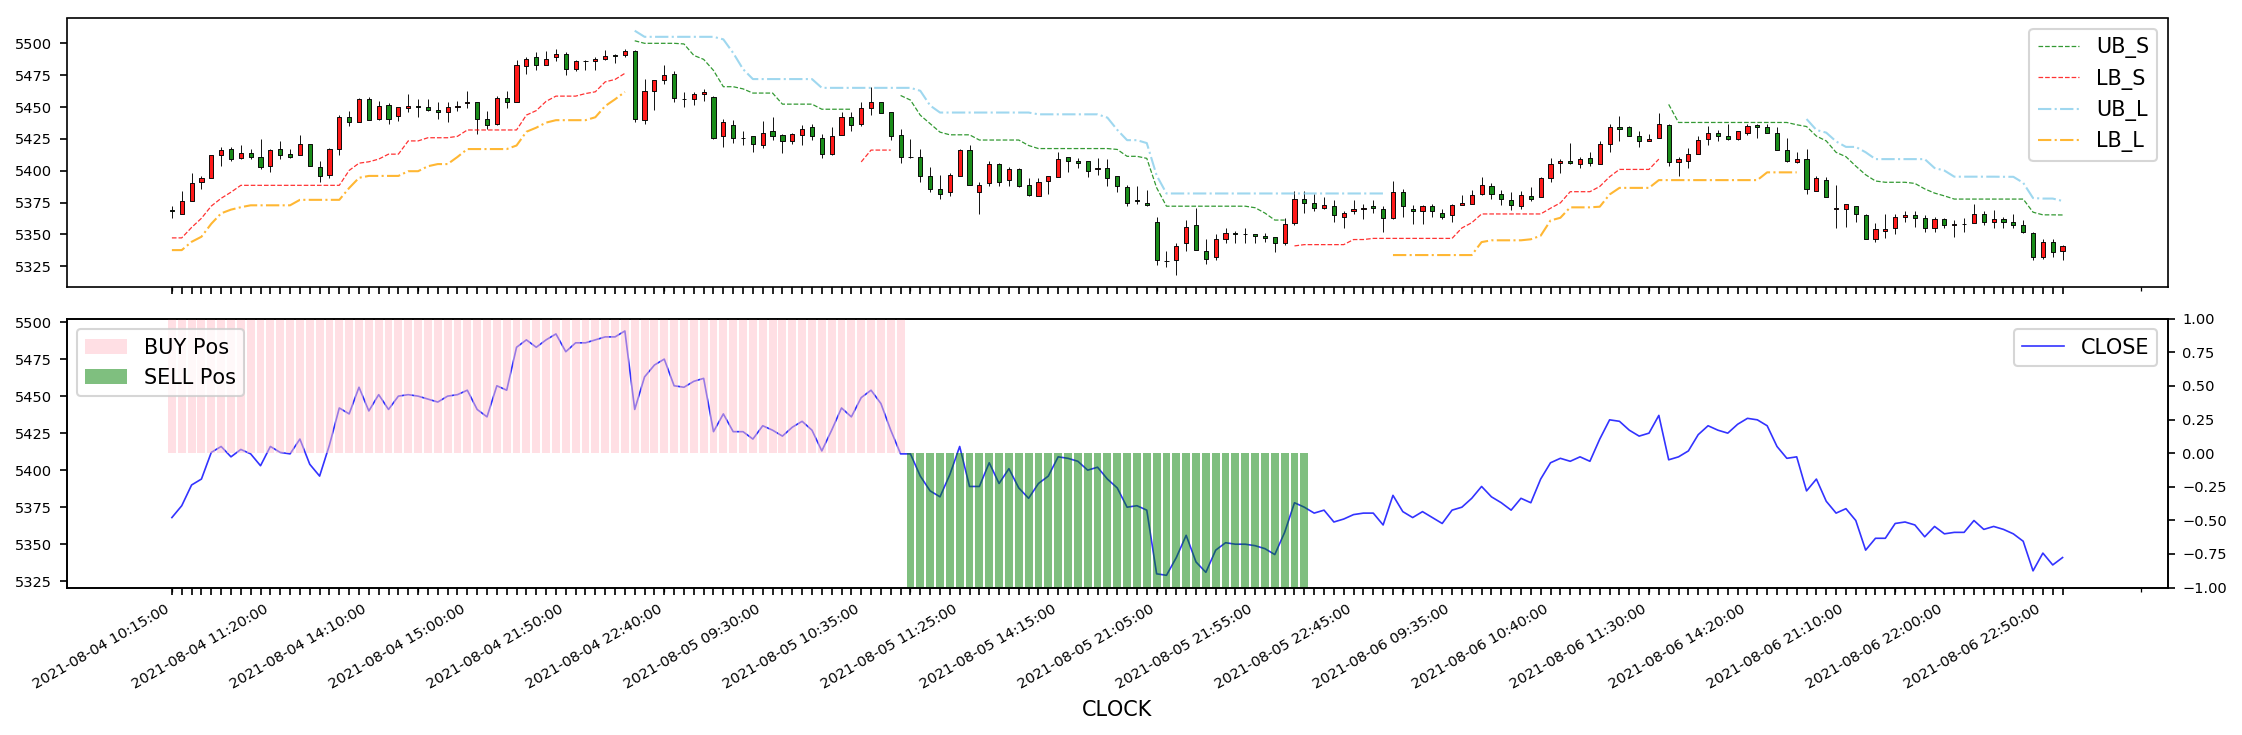

In [51]:
plot_all('rb', '2021-08-04 10:10:00	', '2021-08-07 10:10:00	')

In [5]:
dfc = pd.read_csv('./output/features/v1/bu_features.csv',index_col=0)

In [6]:
dfc

,SYMBOL,CLOCK.1,OPEN,HIGH,LOW,CLOSE,VOLUME,INTEREST,SETTLE,ADJ,...,CLOSE_adj,HIGH_adj,LOW_adj,TR,UB_S,LB_S,STD_S,UB_L,LB_L,STD_L
CLOCK,,,,,,,,,,,,,,,,,,,,,
2013-10-10 09:05:00,R.CN.SHF.bu.0004,2013-10-10 09:05:00,4460.0,4496.0,4452.0,4494.0,22700.0,66086.0,0.0,1.000000,...,4494.0,4496.0,4452.0,44.0,4562.000000,4386.000000,1.0,4606.0,4342.0,1.0
2013-10-10 09:10:00,R.CN.SHF.bu.0004,2013-10-10 09:10:00,4494.0,4512.0,4492.0,4498.0,18042.0,65858.0,0.0,1.000000,...,4498.0,4512.0,4492.0,20.0,4562.000000,4438.000000,1.0,4598.0,4406.0,1.0
2013-10-10 09:15:00,R.CN.SHF.bu.0004,2013-10-10 09:15:00,4498.0,4512.0,4488.0,4494.0,11304.0,65596.0,0.0,1.000000,...,4494.0,4512.0,4488.0,24.0,4558.666667,4441.333333,1.0,4588.0,4412.0,1.0
2013-10-10 09:20:00,R.CN.SHF.bu.0004,2013-10-10 09:20:00,4494.0,4494.0,4484.0,4490.0,6080.0,66170.0,0.0,1.000000,...,4490.0,4494.0,4484.0,10.0,4538.000000,4441.333333,1.0,4562.5,4415.5,1.0
2013-10-10 09:25:00,R.CN.SHF.bu.0004,2013-10-10 09:25:00,4490.0,4494.0,4486.0,4486.0,3886.0,66962.0,0.0,1.000000,...,4486.0,4494.0,4486.0,8.0,4532.400000,4447.600000,1.0,4553.6,4426.4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-19 14:40:00,R.CN.SHF.bu.0004,2022-08-19 14:40:00,3977.0,3978.0,3962.0,3965.0,5932.0,476718.0,0.0,0.479629,...,3965.0,3978.0,3962.0,16.0,3983.300000,3958.900000,-1.0,4001.2,3948.1,-1.0
2022-08-19 14:45:00,R.CN.SHF.bu.0004,2022-08-19 14:45:00,3964.0,3967.0,3958.0,3958.0,6000.0,475910.0,0.0,0.479629,...,3958.0,3967.0,3958.0,9.0,3983.300000,3958.900000,-1.0,3997.3,3948.1,-1.0
2022-08-19 14:50:00,R.CN.SHF.bu.0004,2022-08-19 14:50:00,3958.0,3961.0,3945.0,3948.0,12690.0,475331.0,0.0,0.479629,...,3948.0,3961.0,3945.0,16.0,3977.400000,3928.600000,-1.0,3989.3,3948.1,-1.0
